# Category 4

RNN 을 활용한 텍스트 분류 (Text Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

NLP QUESTION

For this task you will build a classifier for the sarcasm dataset
The classifier should have a final layer with 1 neuron activated by sigmoid as shown.<br/><br/>
It will be tested against a number of sentences that the network hasn't previously seen<br/>
And you will be scored on whether sarcasm was correctly detected in those sentences


-------------------------------
**자연어 처리**<br/><br/>
이 작업에서는 sarcasm 데이터 세트에 대한 분류기를 작성합니다.
분류기는 1 개의 뉴런으로 이루어진 sigmoid 활성함수로 구성된 최종 층을 가져야합니다.<br/>
제출될 모델은 데이터셋이 없는 여러 문장에 대해 테스트됩니다.
그리고 당신은 그 문장에서 sarcasm 판별이 제대로 감지되었는지에 따라 점수를 받게 될 것입니다


-----------------------------------


## 필요한 모듈 import

In [1]:
import json
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## 필요한 데이터 셋 다운로드

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x7f04f31a6310>)

## Json 파일 로드

`datas` 변수에 `json`을 활용하여 로드

In [3]:
with open('sarcasm.json') as f:
    datas = json.load(f)

`datas` 5개  출력

* `article_link`: 뉴스 기사 URL
* `headline`: 뉴스기사의 제목
* `is_sarcastic`: 비꼬는 기사 여부 (비꼼: 1, 일반: 0)

In [4]:
datas[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

## 전처리: 데이터셋 구성(sentences, labels)

* X (Feature): sentences
* Y (Label): label

빈 list를 생성합니다. (sentences, labels)

In [5]:
sentences = []
labels = []

In [6]:
for data in datas:
    sentences.append(data['headline'])
    labels.append(data['is_sarcastic'])

문장 5개를 출력합니다.

In [7]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [8]:
labels[:5]

[0, 0, 1, 1, 0]

## Train / Validation Set 분리

20,000개를 기준으로 **데이터셋을 분리**합니다.


In [9]:
training_size = 20000

In [13]:
train_sentences = sentences[:training_size]  # 20000개 전까지
train_labels = labels[:training_size]

In [12]:
validation_sentences = sentences[training_size:] # 20000개 이후 부터 
validation_labels = labels[training_size:]

## 전처리 Step 1. Tokenizer 정의

단어의 토큰화를 진행합니다.

* `num_words`: 단어 max 사이즈를 지정합니다. 가장 **빈도수가 높은** 단어부터 저장합니다.
* `oov_token`: 단어 토큰에 없는 단어를 어떻게 표기할 것인지 지정해줍니다.

In [16]:
vocab_size = 1000  # 빈도수 높은 단어 기준, 1000개 활용한 단어 한정
oov_tok = "<OOV>"  #oov : out of vocab

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

## 전처리 Step 2. Tokenizer로 학습시킬 문장에 대한 토큰화 진행

`fit_on_texts`로 학습할 문장에 대하여 **토큰화**를 진행합니다.

In [18]:
tokenizer.fit_on_texts(train_sentences)

In [19]:
for key, value in tokenizer.word_index.items():
    print('{}  \t======>\t {}'.format(key, value))
    if value == 25:
        break

<OOV>  	======>	 1
to  	======>	 2
of  	======>	 3
the  	======>	 4
in  	======>	 5
for  	======>	 6
a  	======>	 7
on  	======>	 8
and  	======>	 9
with  	======>	 10
is  	======>	 11
new  	======>	 12
trump  	======>	 13
man  	======>	 14
from  	======>	 15
at  	======>	 16
about  	======>	 17
you  	======>	 18
by  	======>	 19
this  	======>	 20
after  	======>	 21
be  	======>	 22
up  	======>	 23
out  	======>	 24
that  	======>	 25


토큰화된 **단어 사전의 갯수**

In [20]:
len(tokenizer.word_index)

25637

단어사전은 **dictionary** 형태로 되어 있습니다. 

즉, 단어를 key로 입력하면 값을 return 합니다.

In [21]:
word_index = tokenizer.word_index

In [22]:
word_index['trump']

13

In [23]:
word_index['hello']

11724

In [24]:
word_index['<OOV>']

1

## 전처리 Step 3. 문장(sentences)을 토큰으로 변경 (치환)

`texts_to_sequences`: 문장을 숫자로 **치환** 합니다. Train Set, Valid Set 모두 별도로 적용해주어야 합니다.

In [27]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)

# 단어사전에 기반, 문장을 숫자로 변환

**변환된 Sequences 확인**

In [28]:
train_sequences[:5]

[[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1],
 [4, 1, 1, 1, 23, 2, 161, 1, 390, 1, 6, 251, 9, 889],
 [153, 890, 2, 891, 1, 1, 595, 1, 221, 133, 36, 45, 2, 1],
 [1, 38, 213, 382, 2, 1, 29, 288, 23, 10, 1, 1, 1, 958],
 [715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]]

변환 과정에서 '<OOV>'로 **변환된 단어** 확인

빈도수로 지정한 `num_words`=1000 에 의거하여, 빈도수가 1000번째보다 떨어지는 단어는 자동으로 1로 치환됩니다.

1은 '<OOV>' 입니다. (Out of Vocab)

In [29]:
train_sentences[4]

'j.k. rowling wishes snape happy birthday in the most magical way'

In [30]:
word_index['j'], word_index['k'], word_index['rowling'], word_index['wishes'], word_index['snape'], word_index['happy']

(715, 672, 5652, 1043, 8865, 662)

In [31]:
train_sequences[4]

[715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]

## 전처리 Step 4. 시퀀스의 길이를 맞춰주기

3가지 옵션을 입력해 줍니다.

* `maxlen`: 최대 문장 길이를 정의합니다. 최대 문장길이보다 길면, 잘라냅니다.
* `truncating`: 문장의 길이가 `maxlen`보다 길 때 앞을 자를지 뒤를 자를지 정의합니다.
* `padding`: 문장의 길이가 `maxlen`보다 짧을 때 채워줄 값을 앞을 채울지, 뒤를 채울지 정의합니다.

In [32]:
# 한 문장의 최대 단어 숫자
max_length = 120

# 잘라낼 문장의 위치
trunc_type='post'  # cf : 'pre'

# 채워줄 문장의 위치
padding_type='post'

In [34]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# 변환된 sequence 를 넣어 주어야 함 : train_sequences 

변환된 후 shape 확인

In [35]:
train_padded.shape

(20000, 120)

In [36]:
train_padded[0]   # 1 : oov, 0 : padding 으로 채워준 부분, 전체 :120 

array([328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

## 전처리 Step 5. label 값을 numpy array로 변환

model이 `list` type은 받아들이지 못하므로, numpy array로 변환합니다.

In [37]:
type(train_labels)

list

In [38]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

-------------------------------------------------------------


## Embedding Layer

**고차원을 저차원으로 축소**시켜주는 역할을 합니다.

one-hot encoding을 진행했을 때, 1000차원으로 표현되는 단어들을 16차원으로 줄여주는 겁니다. 그렇게 해서 `sparsity`문제를 해소하도록 유도합니다.

In [41]:
embedding_dim = 16  # 1000차원 >> 16차원 

**변환 전**

In [42]:
sample = np.array(train_padded[0])
sample

array([328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

**변환 후**

In [43]:
x = Embedding(vocab_size, embedding_dim, input_length=max_length)
x(sample)[0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.04515411,  0.03879601,  0.01563693,  0.04105523,  0.00675754,
       -0.04075705, -0.04870513,  0.00647528,  0.01895989, -0.01232221,
       -0.01970738,  0.03858322, -0.04874506,  0.00864475,  0.0395021 ,
       -0.04338929], dtype=float32)>

## 모델 정의 (Sequential)

In [45]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # return_sequences=True  옵션 반드시 사용 
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

요약 확인

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,961
Trainable params: 160,961
Non-trainable params: 0
________________________________________________

128 : 64*2 (bidirection) 

## 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 이진 분류이기 때문에 `binary_crossentropy`를 사용합니다.

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [48]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

## 학습 (fit)

In [49]:
epochs=10

In [50]:
history = model.fit(train_padded, train_labels, 
                    validation_data=(validation_padded, validation_labels),
                    callbacks=[checkpoint],
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 26s 26ms/step - loss: 0.4563 - acc: 0.7773 - val_loss: 2.3675 - val_acc: 0.4367

Epoch 00001: val_loss improved from inf to 2.36745, saving model to my_checkpoint.ckpt
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 0.4598 - acc: 0.7718 - val_loss: 0.5244 - val_acc: 0.7302

Epoch 00002: val_loss improved from 2.36745 to 0.52441, saving model to my_checkpoint.ckpt
Epoch 3/10
625/625 [==============================] - 14s 22ms/step - loss: 0.4134 - acc: 0.8115 - val_loss: 0.4268 - val_acc: 0.7968

Epoch 00003: val_loss improved from 0.52441 to 0.42684, saving model to my_checkpoint.ckpt
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3868 - acc: 0.8255 - val_loss: 0.4229 - val_acc: 0.8044

Epoch 00004: val_loss improved from 0.42684 to 0.42289, saving model to my_checkpoint.ckpt
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3672 - acc: 0.8313 - v

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [51]:
model.load_weights(checkpoint_path)

## 학습 오차에 대한 시각화

In [52]:
import matplotlib.pyplot as plt

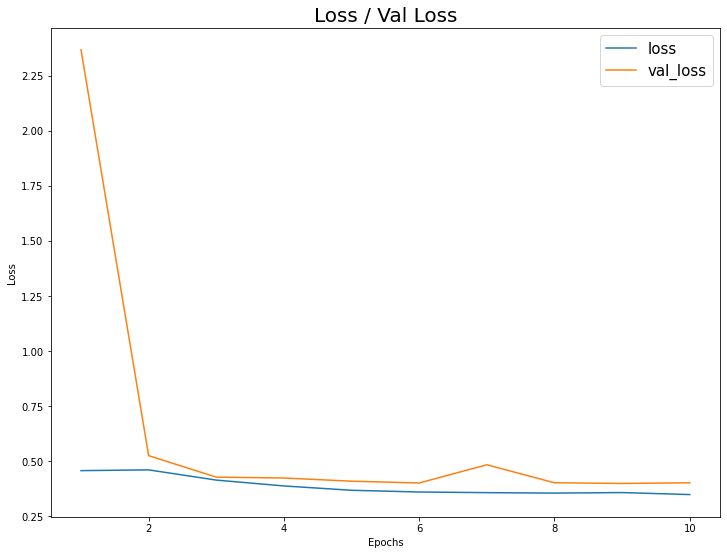

In [53]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

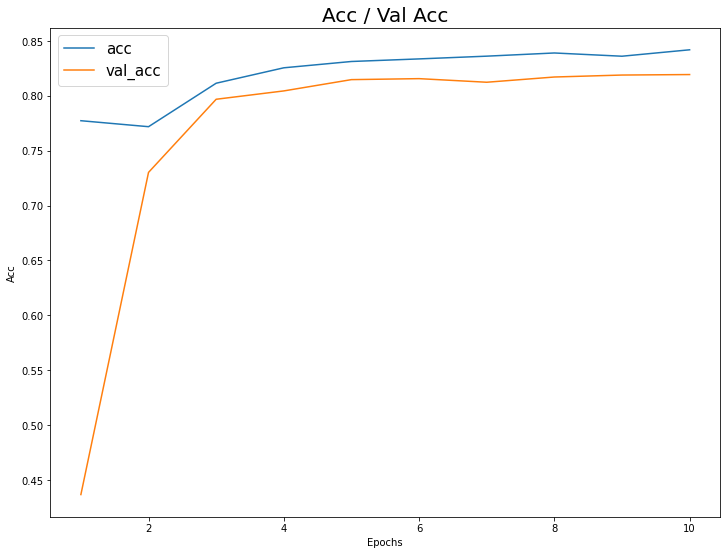

In [54]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()